Paper 
# Active clustering

In [99]:
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Load a XES file and exploration

In [100]:
from pm4py.objects.log.importer.xes import factory as xes_import_factory
log = xes_import_factory.apply('PrepaidTravelCost.xes')

print(
    'length of trace', len(log),
    '\nlength of event', sum(len(trace) for trace in log)
)

length of trace 2099 
length of event 18246


# Filtering out some variatns 

In [101]:
from pm4py.algo.filtering.log.variants import variants_filter
variants = variants_filter.get_variants(log)

from pm4py.statistics.traces.log import case_statistics
variants_count= case_statistics.get_variant_statistics(log)

# Definition of required functions

In [102]:
def add_frequency_into_variants_count(variants_count) : 
    #total sum
    s = 0 
    for i in range(len(variants_count)) : 
        s += variants_count[i]['count'] 

    #frequency 
    for i in range(len(variants_count)) : 
        variants_count[i]['freq']  = variants_count[i]['count'] / s
        if i == 0 : 
            variants_count[i]['acc_freq']  = variants_count[i]['freq']
        else : 
            variants_count[i]['acc_freq'] = variants_count[i-1]['acc_freq'] + variants_count[i]['freq']
    return variants_count

In [103]:
#GL, grouped event log = A collection of dpi. Used the same notation in the paper.
GL = add_frequency_into_variants_count(variants_count)

In [104]:
def dist_btw_set(trace1,trace2, output=False) : 
    A = set(trace1.split(','))
    B = set(trace2.split(','))
    if output : 
        print("\nA SET", A)
        print("\nB SET", B)
        print("\nUNION", A.union(B))
        print("\nINTERSECTION", A.intersection(B))
        print("\nDIFFERENCE", A.union(B) - A.intersection(B))
    return(len(A.union(B) - A.intersection(B)))

In [330]:
from pm4py.algo.discovery.heuristics import factory as heuristics_miner
from pm4py.evaluation.replay_fitness import factory as replay_factory

def look_ahead(log :list, C, R) : 
    print("look_ahead run")
    C_log = variants_filter.apply(log, C) 
    net, im, fm = heuristics_miner.apply(C_log)
    for i, r in enumerate(R) : 
        if i%10 == 0 :
            print("\t = {} dpi(s) checked".format(i))
        r_log = variants_filter.apply(log, r) 
        fit = replay_factory.apply(r_log, net, im, fm )
        if fit['averageFitness'] == 1 : 
            print("\tFound a perfect fitness - {}".format(r))
            R.remove(r)
            C.append(r)
    print("completed look_ahead()")
    print("="*100)
    return C, R

In [331]:
from pm4py.algo.discovery.heuristics import factory as heuristics_miner
from pm4py.evaluation.replay_fitness import factory as replay_factory

def fit_check_w_HM(log :list, cur_dpi :list, C :list) -> float: 
    log = variants_filter.apply( # get the log containing variants in C 
            log, 
            [c for c in C + [cur_dpi]]  
    ) 
#     net, im, fm = heuristics_miner.apply(log, parameters={"dependency_thresh": 0.99})
    net, im, fm = heuristics_miner.apply(log)
    fit = replay_factory.apply(log, net, im, fm )
    return fit['averageFitness']

In [332]:
def W_creater (log, R, w):
    
    W = []
    log = variants_filter.apply(log,R)
    target_size = len(log) * w  #it determines the size of W 
    variant = case_statistics.get_variant_statistics(log)
    print("="*100, "\nW creater called with w : {} and target size {}\n".format(w, target_size), "="*100)
    W_size = 0
    for v in variant :
        if v['count'] + W_size < target_size :
            W_size += v['count']
            W.append(v['variant'])
            print("\t\t", v['variant'][:40], "is added", W_size, "out of", target_size)
    print("="*100)
    print("W creater END\n")
    print("="*100)
    return W

In [333]:
def min_distance_seeker(dpi, C) :
    import sys
    min_dist = sys.maxsize #Instead of inf. 
    for c in C : 
        if min_dist > dist_btw_traces(dpi,c) : 
            min_dpi = c
    return min_dpi

# HERUSTIC MINER

In [339]:
def clustering(C, I, R, log, mcs): 
    print("===== Clustering is called. target size of cluster {}===============".format(mcs * len(R)))
    fit=1.0
    while (len(R)>0 and R != I) :  #line 8 
        W = W_creater(log, list(set(R) - set(I)), 0.4)
        min_avg_dist = len(activities) #dist cannot be larger than the number of all activities 
        cur_dpi = []
        
        if (len(C) ==0 or len(W) == 1) : #if C is empty set
            print("\n\nC is empty set. R[0] is to be added")
            cur_dpi = R[0] #R is already sorted in increasing order. 
            print("\tcur_dpi = R[0]", cur_dpi, "\n\n")
            W.remove(cur_dpi) ###########################################################################33 checked ##############
        else :
            print("\n\nC is not empty set, so w in W to be selected with min_dist")
            for w in W : 
                sum_dist = 0
                for c in C : 
                    sum_dist += dist_btw_set(w,c)
                
                if sum_dist / len(C) < min_avg_dist : 
                    min_avg_dist = sum_dist / len(C)
                    cur_dpi = w
                    print("\tUPDATED cur_dpi in the loop|",cur_dpi[:40], "\t",min_avg_dist)
        print("\n\tcur_dpi :{} dist {}".format(cur_dpi[:40],min_avg_dist))
        fit = fit_check_w_HM(log, cur_dpi, C)
        if fit > tf : 
            print("[fit>tf] - current fitness {}, target fitness {}".format(fit,tf))
            R.remove(cur_dpi)
            C.append(cur_dpi) # added to C
#             C = list(set(C)) # remove from R
#             HM_Draw(log,C)
       
        else : # if fit < tf
            print("[fit<tf] fitness is lower than the target fitness {} vs {}.".format(fit, tf) )
            if len(C) > mcs * len(R) :
                print("\tlook_ahead is called and this clustering is completed".format(fit, tf) )
                print(
                    "\t\tsize of C : {} / size of R {} / size of I{}\n\n"
                    .format(len(C), len(R), len(I))
                )
                C,R = look_ahead(log,C,R)
                return C,I,R
            else :
                print("still it need more trace")
                I.append(cur_dpi)
        print("-"*100)        
        print(
            "END OF SINGLE LOOP ___ fitness : {} / size of C : {} / size of R {} / size of I{}"
            .format(fit, len(C), len(R), len(I))
        )
        print("-"*100)
        print("\n\n\n")
        
    return C,I,R

# MAIN DRIVING HERE 

In [340]:

w = 0.5  #window size
tf = 0.95 #target fitness
nb_clus = 3 #number of cluster
N = 1 #case separate 
mcs = 0.01


In [341]:
# corresponding to the line 3 in the paper. 
R=[]
C=[]
I=[]
CS=[]
i=0
for gl in GL: 
    R.append(gl['variant'])
    
R_variants_count = GL
activities=[]
for r in R : 
    activities +=  (r.split(','))
    activities = list(set(activities)) #set of all activities in the log


In [345]:
for i in range(nb_clus) : 
    print("\n\n\n{} cluster to be created".format(i))
    C = []
    C, I, R = clustering(C, I, R, log,mcs)
    CS.append(C)





0 cluster to be created
===== Clustering is called. target size of cluster 1.94===============
W creater called with w : 0.4 and target size 388.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 126 out of 388.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 226 out of 388.0
		 Permit SBMTD by E,Permit APPRD by PRE_AP is added 316 out of 388.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 369 out of 388.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 383 out of 388.0
		 Permit SBMTD by E,Permit APPRD by S,Perm is added 387 out of 388.0
W creater END



C is empty set. R[0] is to be added
	cur_dpi = R[0] Permit SBMTD by E,Permit APPRD by ADMIN,Permit APPRD by S,Permit F_APRD by DIRECTOR,Req For Pay SBMTD by E,Req For Pay APPRD by ADMIN,Req For Pay F_APRD by S,Req Pay,Pay Handled 



	cur_dpi :Permit SBMTD by E,Permit APPRD by ADMIN, dist 29
[fit>tf] - current fitness 1.0, target fitness 0.95
--------------------------------------------------------------------

[fit>tf] - current fitness 0.9568965517241357, target fitness 0.95
----------------------------------------------------------------------------------------------------
END OF SINGLE LOOP ___ fitness : 0.9568965517241357 / size of C : 3 / size of R 189 / size of I0
----------------------------------------------------------------------------------------------------




W creater called with w : 0.4 and target size 228.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 53 out of 228.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 81 out of 228.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 107 out of 228.0
		 Permit SBMTD by E,Permit APPRD by S,Perm is added 128 out of 228.0
		 Req For Pay SBMTD by E,Req For Pay REJ.  is added 148 out of 228.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 162 out of 228.0
		 Req For Pay SBMTD by E,Req For Pay F_APR is added 175 out of 228.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 188 out of 228.0
		 Permit SBMTD by E

[fit>tf] - current fitness 0.9635049449864268, target fitness 0.95
----------------------------------------------------------------------------------------------------
END OF SINGLE LOOP ___ fitness : 0.9635049449864268 / size of C : 8 / size of R 184 / size of I0
----------------------------------------------------------------------------------------------------




W creater called with w : 0.4 and target size 200.4
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 53 out of 200.4
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 81 out of 200.4
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 107 out of 200.4
		 Req For Pay SBMTD by E,Req For Pay REJ.  is added 127 out of 200.4
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 140 out of 200.4
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 153 out of 200.4
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 165 out of 200.4
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 174 out of 200.4
		 Permit SBMTD by E

[fit>tf] - current fitness 0.9504167773155129, target fitness 0.95
----------------------------------------------------------------------------------------------------
END OF SINGLE LOOP ___ fitness : 0.9504167773155129 / size of C : 12 / size of R 180 / size of I0
----------------------------------------------------------------------------------------------------




W creater called with w : 0.4 and target size 171.20000000000002
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 28 out of 171.20000000000002
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 54 out of 171.20000000000002
		 Req For Pay SBMTD by E,Req For Pay REJ.  is added 74 out of 171.20000000000002
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 87 out of 171.20000000000002
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 100 out of 171.20000000000002
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 112 out of 171.20000000000002
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 121 out of 171.20

[fit>tf] - current fitness 0.9696969696969697, target fitness 0.95
----------------------------------------------------------------------------------------------------
END OF SINGLE LOOP ___ fitness : 0.9696969696969697 / size of C : 2 / size of R 174 / size of I0
----------------------------------------------------------------------------------------------------




W creater called with w : 0.4 and target size 152.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 26 out of 152.0
		 Req For Pay SBMTD by E,Req For Pay REJ.  is added 46 out of 152.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 59 out of 152.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 72 out of 152.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 84 out of 152.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 93 out of 152.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 101 out of 152.0
		 Permit SBMTD by E,Permit APPRD by ADMIN, is added 109 out of 152.0
		 Req For Pay SAVED by 

In [356]:
len(CS)

4

In [358]:
CS[3]

['Permit SBMTD by E,Permit APPRD by ADMIN,Req For Pay SBMTD by E,Req For Pay APPRD by ADMIN,Permit APPRD by BUDGET OWNER,Req For Pay APPRD by BUDGET OWNER,Permit F_APRD by S,Req For Pay F_APRD by S,Req Pay,Pay Handled',
 'Permit SBMTD by E,Permit APPRD by ADMIN,Req For Pay SBMTD by E,Req For Pay APPRD by ADMIN,Req For Pay APPRD by BUDGET OWNER,Permit APPRD by BUDGET OWNER,Req For Pay F_APRD by S,Permit F_APRD by S,Req Pay,Pay Handled',
 'Permit SBMTD by E,Permit APPRD by ADMIN,Req For Pay SBMTD by E,Req For Pay APPRD by ADMIN,Permit APPRD by BUDGET OWNER,Permit F_APRD by S,Req For Pay APPRD by BUDGET OWNER,Req For Pay F_APRD by S,Req Pay,Pay Handled',
 'Permit SBMTD by E,Permit APPRD by ADMIN,Permit APPRD by BUDGET OWNER,Req For Pay SBMTD by E,Req For Pay APPRD by ADMIN,Req For Pay APPRD by BUDGET OWNER,Permit F_APRD by S,Req For Pay F_APRD by S,Req Pay,Pay Handled']

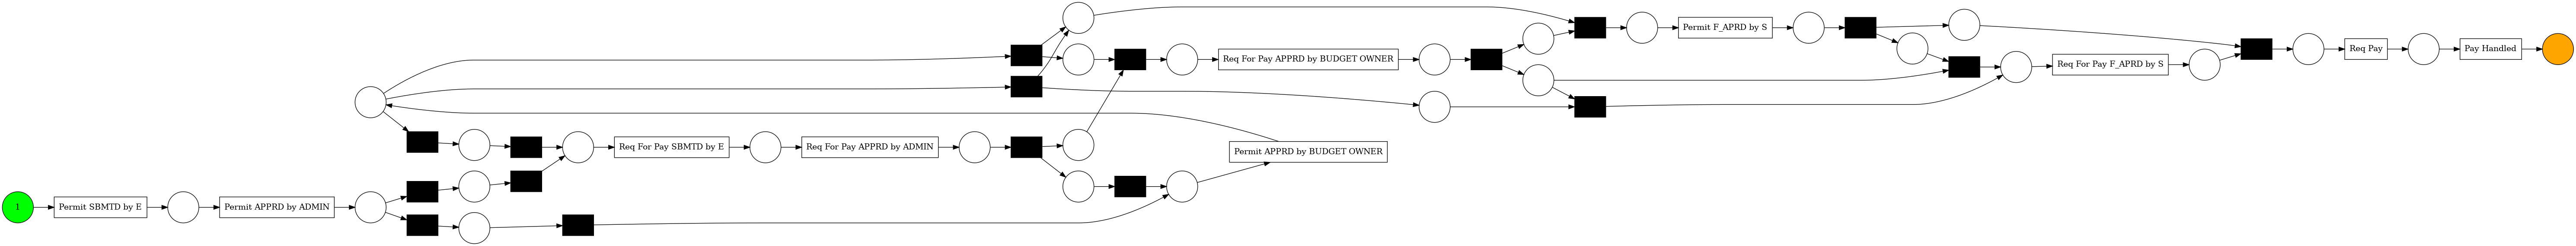

In [357]:

net, im, fm = heuristics_miner.apply(variants_filter.apply(log, CS[3]))

from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm)
pn_vis_factory.view(gviz)

from pm4py.visualization.petrinet import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "jpg"}
gviz = pn_visualizer.apply(net, parameters=parameters)
pn_visualizer.save(gviz, "C.jpg")

In [151]:
a=variants_filter.apply(log, C_backup)

In [153]:
case_statistics.get_variant_statistics(a)[0]

{'variant': 'Permit SBMTD by E,Permit APPRD by ADMIN,Permit F_APRD by S,Req For Pay SBMTD by E,Req For Pay APPRD by ADMIN,Req For Pay F_APRD by S,Req Pay,Pay Handled',
 'count': 569}

In [120]:
print(len(C),len(R), len(I))

14 188 0


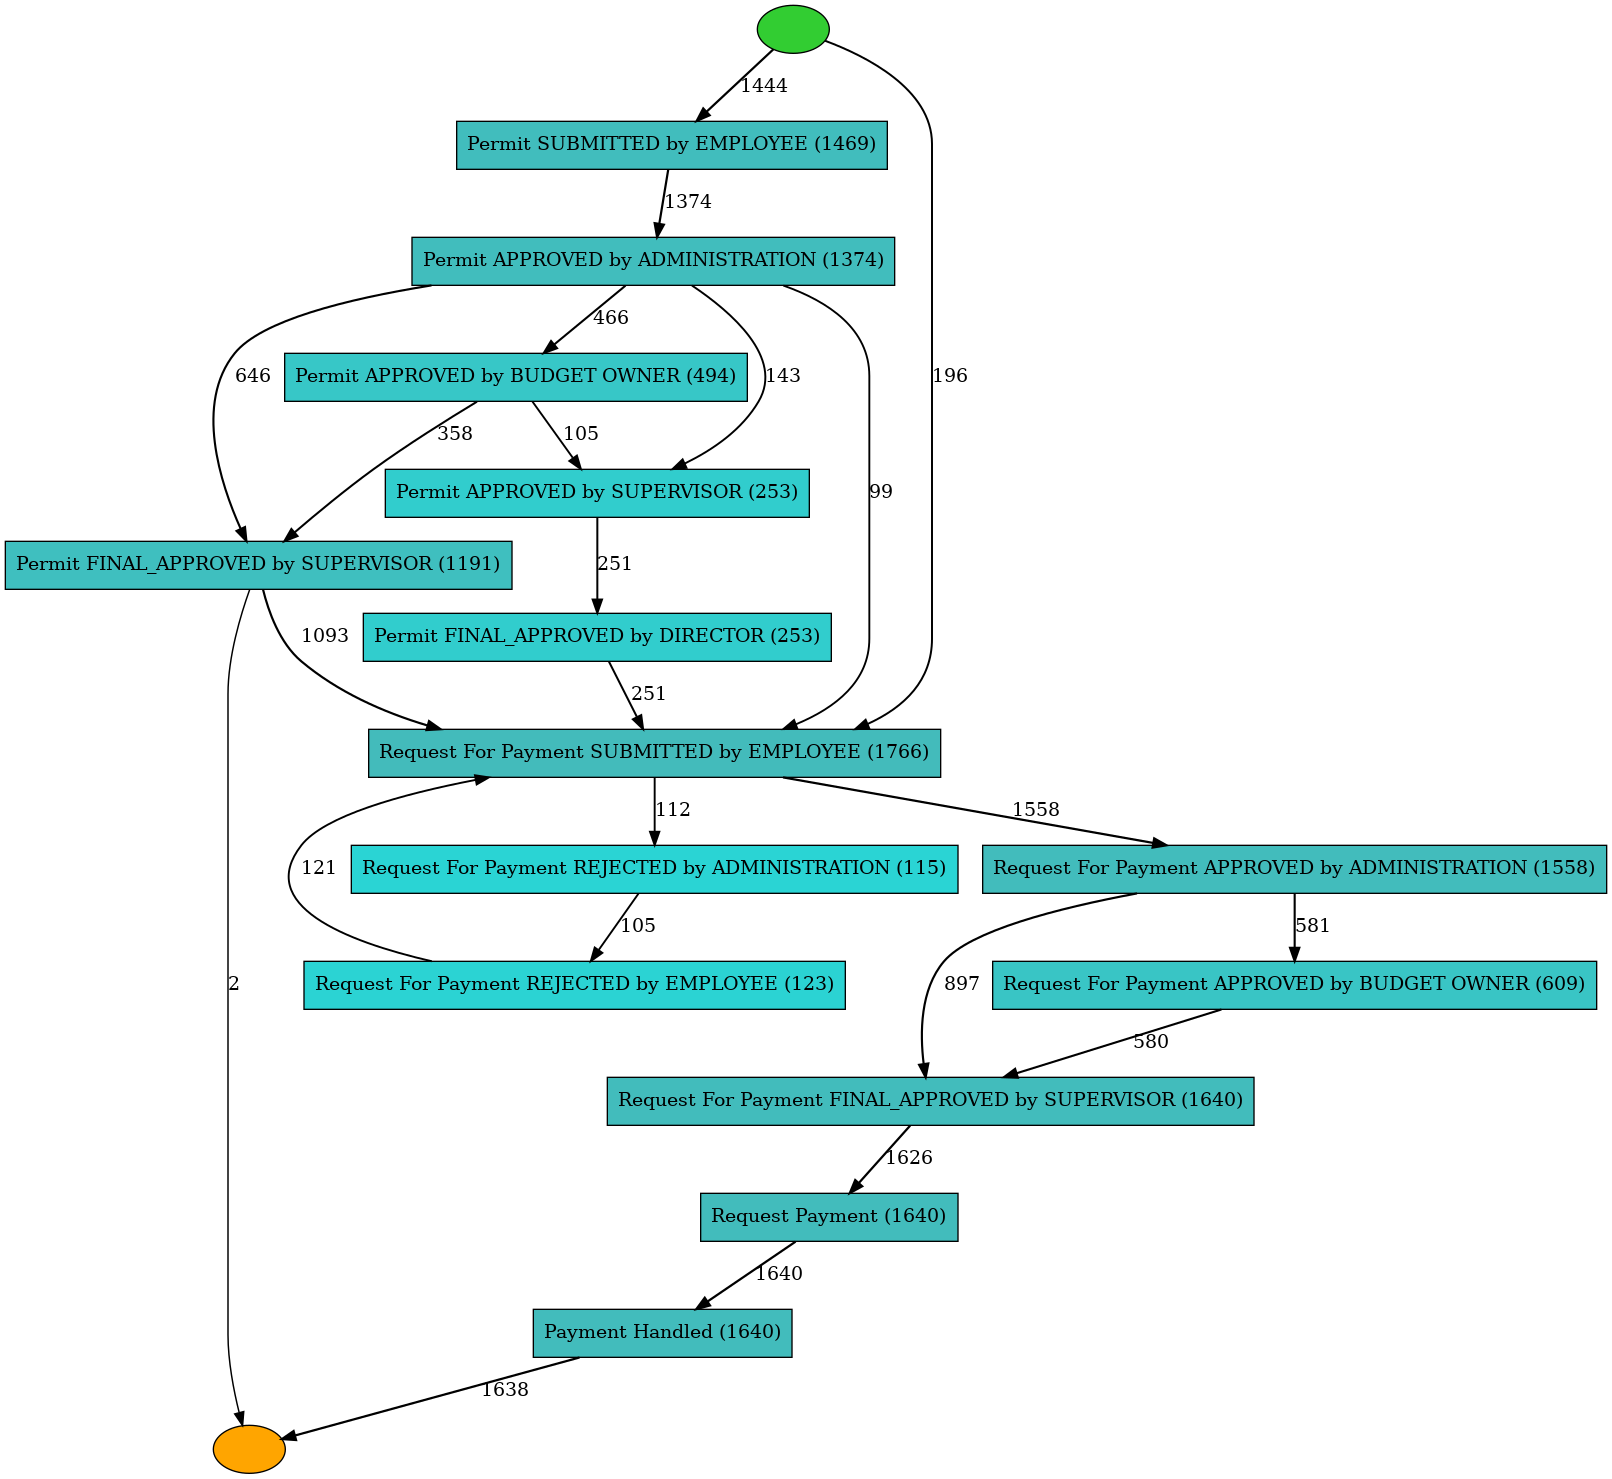

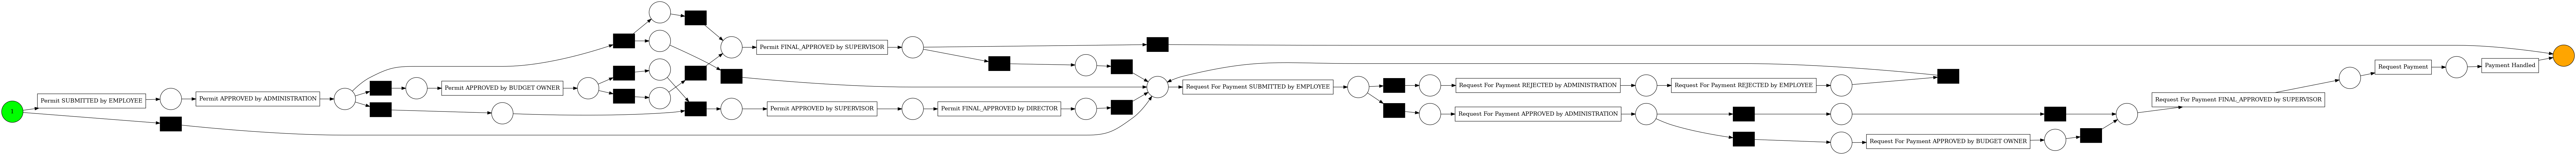

In [79]:
heu_net = heuristics_miner.apply_heu(variants_filter.apply(log, C), parameters={"dependency_thresh": 0.99})
net, im, fm = heuristics_miner.apply(variants_filter.apply(log, C), parameters={"dependency_thresh": 0.99})

from pm4py.visualization.heuristics_net import factory as hn_vis_factory
gviz = hn_vis_factory.apply(heu_net)
hn_vis_factory.view(gviz)

from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm)
pn_vis_factory.view(gviz)


from pm4py.visualization.petrinet import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "svg"}
gviz = pn_visualizer.apply(net, parameters=parameters)
pn_visualizer.save(gviz, "alpha.svg")